In [1]:
from collections import defaultdict
import math
import string

import pandas as pd
import numpy as np
%matplotlib inline

First we count the number of adjacent pair of characters from big blob of text. The text used below is top 100k most common english words taken from https://gist.github.com/h3xx/1976236/raw/bbabb412261386673eff521dddbe1dc815373b1d/wiki-100k.txt

In [2]:
alphabet = set(string.ascii_lowercase + ' ')

# assume minimum count is 100 (for a super simple smoothing) so we won't have prob = 0
counts = defaultdict(lambda: defaultdict(lambda: 100))

with open('wiki-100k.txt') as f:
    for line in f:
        if line.startswith('#'):
            continue
            
        for word in line.strip().lower().split():
            prev_char = None
            for char in word:
                if char not in alphabet:
                    continue
                if prev_char is None:
                    counts[' '][char] += 1
                else:
                    counts[prev_char][char] += 1
                prev_char = char
            counts[prev_char][' '] += 1
counts['a']

defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
            {' ': 3601,
             'a': 515,
             'b': 1840,
             'c': 2575,
             'd': 2132,
             'e': 467,
             'f': 553,
             'g': 1724,
             'h': 486,
             'i': 3060,
             'j': 196,
             'k': 694,
             'l': 5480,
             'm': 2316,
             'n': 8550,
             'o': 179,
             'p': 1605,
             'q': 149,
             'r': 7168,
             's': 3315,
             't': 6272,
             'u': 1724,
             'v': 1203,
             'w': 549,
             'x': 243,
             'y': 976,
             'z': 336})

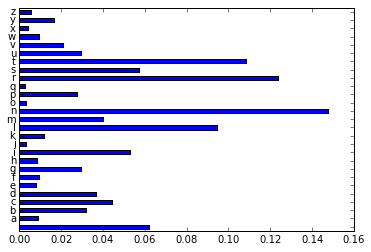

In [3]:
# probability of one char after the other
probs = defaultdict(dict)
for char in alphabet:
    # normalize so we have sum(probs) = 1
    total = sum(counts[char][c] for c in alphabet)
    for next_char in alphabet:
        probs[char][next_char] = counts[char][next_char] / total

pd.Series(probs['a']).plot(kind='barh')

In [4]:
# use log(prob) because multiplying can leads to underflow
# https://squarecog.wordpress.com/2009/01/10/dealing-with-underflow-in-joint-probability-calculations/
log_probs = defaultdict(dict)
for char in alphabet:
    for next_char in alphabet:
        log_probs[char][next_char] = math.log(probs[char][next_char])


def score(word):
    score = 0
    for i in range(len(word) - 1):
        # log(p(ab)) = log(p(a) * p(b)) = log(pa(a)) + log(p(b))
        score += log_probs[word[i]][word[i+1]]
    score += log_probs[' '][word[0]]
    score += log_probs[word[0]][' ']
    return score / len(word)

print(score('adatao'))

-3.6939779797379515


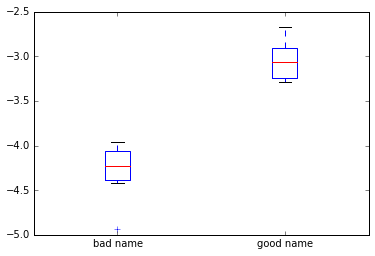

In [5]:
# test our scoring function with some "good" and "bad" names
goods = ['american', 'apple', 'alphabet', 'apache', 'automatic', 'advanced']
bads = ['asaxa', 'asdx', 'asvaxw', 'apssfse', 'axbfa', 'awgsgpasdad']

good_scores = [score(name) for name in goods]
bad_scores = [score(name) for name in bads]

pd.DataFrame({'good name': good_scores, 'bad name': bad_scores}).plot(kind='box')

In [6]:
# let's generate all possible string with given length and score them all

def gen_string(length=1):
    if length <= 0:
        yield ''
    else:
        for c in string.ascii_lowercase:
            for name in gen_string(length - 1):
                yield c + name

def gen_name(min_len=4, max_len=4):
    assert max_len >= min_len
    for n in range(min_len - 1, max_len):
        for name in gen_string(n):
            yield 'a' + name
        
print(list(gen_name(2,2)))

['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av', 'aw', 'ax', 'ay', 'az']


In [7]:
import heapq

heapq.nlargest(10, gen_name(4, 6), key=score)

['arerer',
 'antere',
 'angere',
 'arerin',
 'atinte',
 'areren',
 'aterer',
 'antint',
 'areres',
 'alerer']

A brute force attack turn out to be very slow. At O(26^n), a 8 chars length will have to score 8,031,810,176 possible candidates. However, we already have the probabilities of going from one char to the next, so let's use it to generate name _probablistically_

In [8]:
choices = list(alphabet)
def gen_name_prob(iteration=1000, max_len=8, min_len=3):
    name = 'a'
    current_char = 'a'
    while len(name) < max_len:
        next_char_probs = [probs[current_char][c] for c in choices]
        next_char = np.random.choice(choices, p=next_char_probs)
        if next_char == ' ':
            if len(name) >= min_len:
                return name
        else:
            name += next_char
            current_char = next_char
    else:
        return name
                
[gen_name_prob() for _ in range(10)]

['acteente',
 'atintiyn',
 'ahrertys',
 'antingon',
 'alzjinst',
 'antiarod',
 'and',
 'astinch',
 'araravia',
 'aller']

Also, let's use all 4 powerful cores of my laptop to find a good name instead of one.

In [9]:
import concurrent.futures
import itertools

def top_prob(_):
    return set(heapq.nlargest(100, (gen_name_prob() for _ in range(100000)), key=score))
    
pool = concurrent.futures.ProcessPoolExecutor(4)
candidates = pool.map(top_prob, range(4))
tops = list(set(heapq.nlargest(100, itertools.chain.from_iterable(candidates), key=score)))[:10]
sorted([(name, score(name)) for name in tops], key=lambda x: x[1], reverse=True)

[('antinter', -2.3207943304520984),
 ('atererin', -2.331313912351201),
 ('arintere', -2.33596481114985),
 ('antentin', -2.3419340416204704),
 ('arengere', -2.348734473007067),
 ('arerinti', -2.3574001769881994),
 ('antedere', -2.360871477560078),
 ('anterede', -2.3608714775600785),
 ('alentere', -2.3681243428851118),
 ('aresting', -2.3802431258688714)]